In [1]:
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

2023-11-13 14:47:00.306319: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-11-13 14:47:01.056992: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 14:47:01.057869: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-11-13 14:47:01.058674: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-11-13 14:47:01.107099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node ze

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5



2023-11-13 14:47:01.620659: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-11-13 14:47:01.620685: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      0 
2023-11-13 14:47:01.620691: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 0:   N 
2023-11-13 14:47:01.620896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-13 14:47:01.621118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-13 14:47:01.621365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout

import rasterio

import os

In [3]:
#define paths
train_path = r"/media/daniel/7C42A09342A05424/Users/morae/Desktop/PhD_NovaIMS/Paper 3/Experimentos_DL/Imagem_Sentinel2/Inputs/train"
test_path = r"/media/daniel/7C42A09342A05424/Users/morae/Desktop/PhD_NovaIMS/Paper 3/Experimentos_DL/Imagem_Sentinel2/Inputs/test"


In [4]:
#open images as np array
def imgsToArray(folder_path):
    tif_files = [f for f in os.listdir(folder_path) if f.endswith('.tif') or f.endswith('.tiff')]

    if not tif_files:
        print("No TIF files found in the specified folder.")
        return None

    # Read the first image to get metadata
    with rasterio.open(os.path.join(folder_path, tif_files[0])) as src:
        meta = src.meta
        shape = src.shape
        band_count = src.count        
        

    # Create an empty numpy array to store all images
    all_images = np.empty((len(tif_files), shape[0], shape[1], band_count), dtype=meta['dtype'])

    # Read and store each image in the array
    for i, tif_file in enumerate(tif_files):
        with rasterio.open(os.path.join(folder_path, tif_file)) as src:

            all_images[i, :, :] = np.transpose(src.read(), (1, 2, 0)) #src.read()

    return all_images

x_train = imgsToArray(train_path+'/data')
y_train = imgsToArray(train_path+'/class')
x_test = imgsToArray(test_path+'/data')
y_test = imgsToArray(test_path+'/class')



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


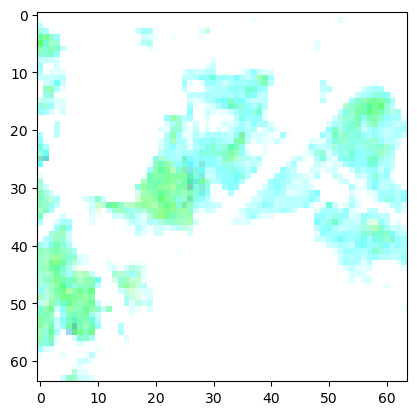

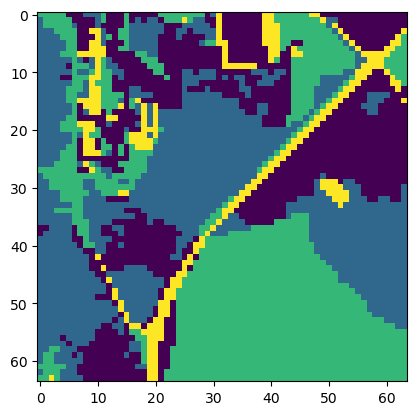

In [5]:
plt.imshow(x_test[3,:,:,:].astype('uint16'))
plt.show()

plt.imshow(y_test[3,:,:,0].astype('uint8'))
plt.show()

In [6]:
from tensorflow.keras.utils import to_categorical

#subtract 1 from y sets
y_train = np.subtract(y_train,1)
y_test = np.subtract(y_test,1)

#one-hot encoding

y_train_1hot = to_categorical(y_train)
y_test_1hot = to_categorical(y_test)

In [7]:
#np.unique(np.load(r"/home/daniel/Downloads/y_test.npy"))

In [8]:
#define model (U-Net)
x_in = Input(shape=(64, 64, 4))

'''Encoder'''
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip1)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip2)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip3)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)

'''Decoder'''
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip3])
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip2])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip1])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)

'''Use 1 by 1 Convolution to get desired output bands'''
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_out = Conv2D(5, (1, 1), activation='softmax', padding='same')(x_temp)

model = Model(inputs=x_in, outputs=x_out)

model.compile(loss='categorical_crossentropy', optimizer='adam')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 4)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   1184        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 64, 64, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   9248        dropout[0][0]                    
______________________________________________________________________________________________

2023-11-13 14:47:11.217782: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-11-13 14:47:11.217931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-13 14:47:11.218127: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: NVIDIA GeForce GTX 1650 SUPER computeCapability: 7.5
coreClock: 1.725GHz coreCount: 20 deviceMemorySize: 3.81GiB deviceMemoryBandwidth: 178.84GiB/s
2023-11-13 14:47:11.218148: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-11-13 14:47:11.218166: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-11-13 14:47:11.218175: I tensorflow/stream_executor/pl

In [24]:
#train
history = model.fit(x_train, y_train_1hot, validation_data=(x_test, y_test_1hot), epochs=1000, batch_size=5, verbose=0)

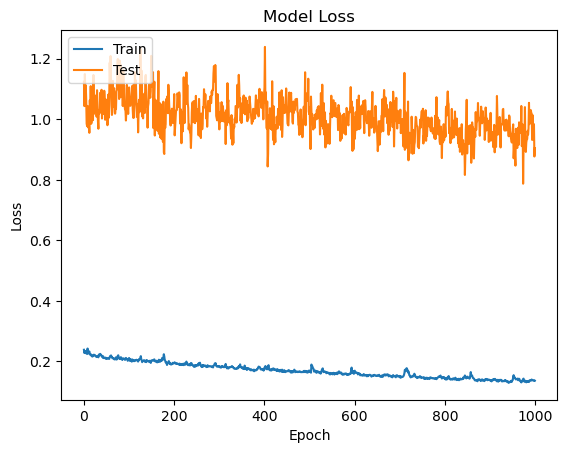

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

(8, 64, 64)


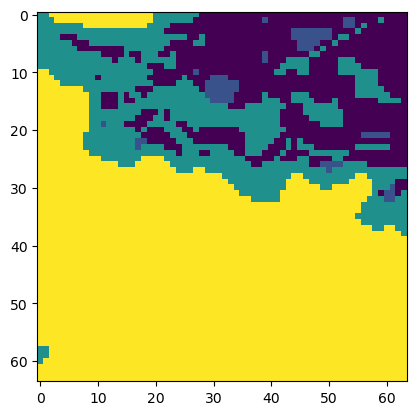

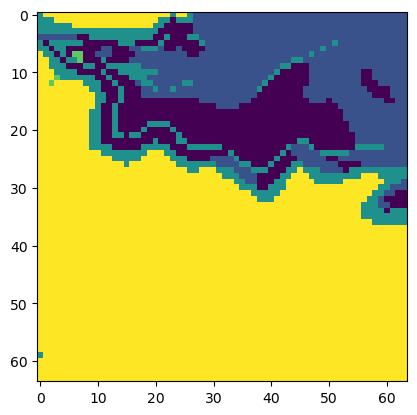

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


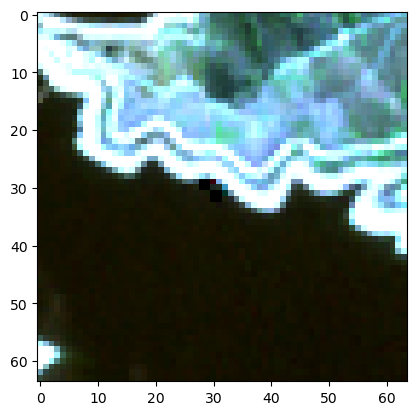

In [26]:
pred_test = model.predict(x_test)

pred_test = np.argmax(pred_test, axis=-1)
print(pred_test.shape)

#let's compare sample predicted and actual land cover image with input RGB image

plt.imshow(pred_test[5, :, :])
plt.show()
plt.imshow(y_test[5, :, :, 0])
plt.show()
plt.imshow(np.divide(x_test,1000)[5,:,:,:3])#.astype('int32'))
plt.show()

In [53]:
#predict and export as tif
with rasterio.open(os.path.join(test_path,'data','sample_data_1.tif')) as src:
    #print(src.read().shape)
    meta = src.meta.copy()
    transform = src.transform
    
    meta.update({
    'dtype': 'uint16',  # Change to the appropriate data type
    'count': 1,  # Number of bands
    })
    
    
    #print(np.array([np.transpose(src.read(), (1, 2, 0))]).shape)
    pred_test = model.predict(np.array([np.transpose(src.read(), (1, 2, 0))]))
    pred_test = np.argmax(pred_test, axis=-1)
    #print(pred_test.shape)
    #np.transpose(src.read(), (1, 2, 0))
    #plt.imshow(pred_test[0, :, :])
    #plt.show()
    #print(meta)
    
    output_tif_path = os.path.join(test_path,'sample_1_preds.tif')
    
    with rasterio.open(output_tif_path, 'w', **meta) as dst:
        # Write the array to the new GeoTIFF file
        dst.write(np.add(pred_test,1))

src = None
dst = None

In [ ]:
#https://stackoverflow.com/questions/62681257/tf-keras-model-predict-is-slower-than-straight-numpy